In [1]:
from SimPEG import *
from simpegem1d import *
from scipy.constants import mu_0
import numpy as np

frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.01)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'Hz',
    src_type = 'VMD',
    offset = np.ones(5)*7.86,
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
)

sig_half = 1e-2
sig_blk = 1e0
chi_half = 0.
wires = Maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = Maps.ExpMap(mesh1D)
# expmap_h = Maps.ExpMap(nP=1)
sigmaMap = expmap * wires.sigma
# hMap = expmap_h*wires.h
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-50>LocSigZ) & (-100<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.r_[np.log(sig), FDsurvey.h]
m_true_dh = np.r_[np.log(sig), FDsurvey.h + 5.]
dh = 0.01
m_dx_p = np.r_[np.log(sig), FDsurvey.h+dh/2]
m_dx_n = np.r_[np.log(sig), FDsurvey.h-dh/2]

In [2]:
prob = EM1D(
    mesh1D, sigmaMap=sigmaMap, hMap=wires.h, filter_type='key_101',
    jacSwitch=True,
    chi= np.zeros(FDsurvey.n_layer),
    verbose=True
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     
d_true = FDsurvey.dpred(m_true)
d_p = FDsurvey.dpred(m_dx_p)
d_n = FDsurvey.dpred(m_dx_n)
d_dh = FDsurvey.dpred(m_true_dh)

>> Use Key 101 filter for Hankel Tranform
>> Compute response
>> Compute response
>> Compute response
>> Compute response


>> Compute J height 


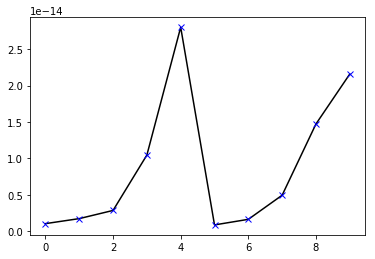

In [3]:
J_h_diff = (d_p-d_n) / (dh)
plt.plot(J_h_diff, 'k')
plt.plot(prob.getJ_height(m_true), 'bx')

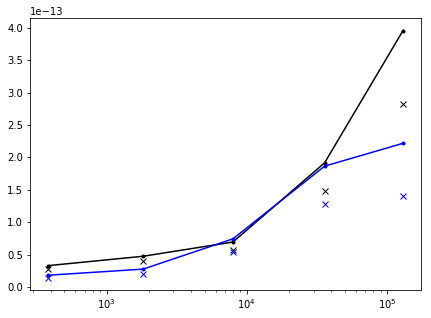

In [4]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, -d_dh[0:FDsurvey.n_frequency], 'kx')
axes.plot(FDsurvey.frequency, -d_dh[FDsurvey.n_frequency:], 'bx')

axes.set_xscale('log')

In [5]:
from SimPEG import Regularization

In [6]:
FDsurvey.dtrue = d_true
std = 0.07
floor = 0.
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)
m0 = np.r_[np.log(np.ones_like(sig)*sig_half), 35.]
reg_sigma = Regularization.Sparse(
    mesh1D, mapping=wires.sigma
)
p=0.
qx, qz = 2., 2.
reg_sigma.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    betaSearch=False,
    chifact_start = 1.
)
mesh_h = Mesh.TensorMesh([1])
reg_h = Regularization.Sparse(
    mesh_h, mapping=wires.h, 
    alpha_s = 1.
)
reg = reg_sigma + reg_h
opt = Optimization.ProjectedGNCG(maxIter = 20)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
>> Compute response
>> Compute J sigma
>> Compute J height 
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
>> Compute response
   0  5.62e+00  2.19e+02  0.00e+00  2.19e+02    6.25e+01      0              


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:896: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


>> Compute response
>> Compute J sigma
>> Compute J height 
   1  5.62e+00  1.55e+02  2.74e+00  1.70e+02    3.90e+01      0              
>> Compute response
>> Compute J sigma
>> Compute J height 
   2  2.81e+00  1.35e+02  4.32e+00  1.47e+02    1.55e+01      0              
>> Compute response
>> Compute J sigma
>> Compute J height 
   3  2.81e+00  9.24e+01  1.18e+01  1.26e+02    1.40e+01      0              
>> Compute response
>> Compute J sigma
>> Compute J height 
   4  1.41e+00  7.74e+01  1.47e+01  9.80e+01    1.39e+01      0              
>> Compute response
>> Compute J sigma
>> Compute J height 
   5  1.41e+00  5.57e+01  2.17e+01  8.63e+01    9.59e+00      0              
>> Compute response
>> Compute J sigma
>> Compute J height 
   6  7.03e-01  4.29e+01  2.63e+01  6.14e+01    1.58e+01      0   Skip BFGS  
>> Compute response
>> Compute J sigma
>> Compute J height 
   7  7.03e-01  1.52e+01  3.84e+01  4.22e+01    9.45e+00      0              
>> Compute response
>> Compute J s

In [7]:
print (wires.h*m0)
print (wires.h*mopt)
print (FDsurvey.h)

[35.]
[30.62228625]
30.0


Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'beta', 'inv', 'floor', 'pi', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


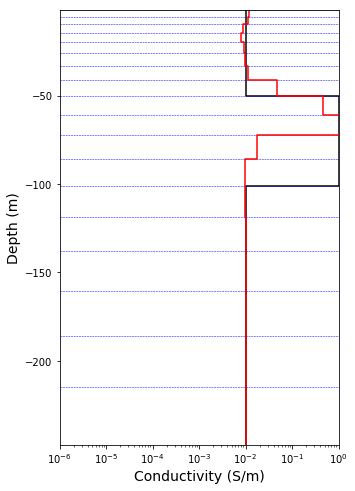

In [8]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(sigmaMap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e0), **{'color':'r'})
# Utils1D.plotLayer(expmap*invProb.l2model, LocSigZ, showlayers=True,xlim=(1e-6, 1e0), **{'color':'r'})

In [9]:
# !python run_em1d.py

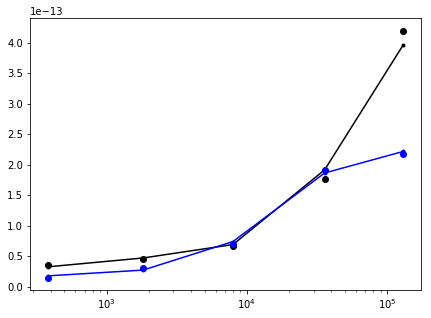

In [10]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.n_frequency], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.n_frequency:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.n_frequency], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.n_frequency:], 'r*')
axes.set_xscale('log')